In [52]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shlex
from scipy.stats import ttest_rel,ttest_ind,wilcoxon,ranksums,pearsonr,spearmanr
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import explained_variance_score,mean_squared_error
from statsmodels.stats.multitest import multipletests
import subprocess
import scipy
import sys
sys.path.append("../code")
from analysis_utils import *

In [55]:
sns.set_context('notebook',font_scale=1.5)

In [59]:
df = pd.read_table('../data/Pioneer_TF_library.csv')

In [60]:
expts = ['rarrxr1_slotv4_endoderm_rep1a',
         'rarrxr1_slotv4_endoderm_rep1b',
         'rarrxr1_slotv4_endoderm_rep2a',
         'rarrxr1_slotv4_endoderm_rep2b',
         'rarrxr1_slotv4_mesc_repa',
         'rarrxr1_slotv4_mesc_repb']
for expt in expts:
    df[expt+'_dpnii_norm'] = df[expt+'_dpnii']/(np.sum(df[expt+'_dpnii'])/1000000)
    df[expt+'_dpni_norm'] = df[expt+'_dpni']/(np.sum(df[expt+'_dpni'])/1000000)
    df[expt+' Dpn Ratio'] = df[expt+'_dpnii_norm']/(df[expt+'_dpnii_norm']+df[expt+'_dpni_norm'])
df['ES Dpn ratio'] = (df['rarrxr1_slotv4_mesc_repa Dpn Ratio'] +df['rarrxr1_slotv4_mesc_repb Dpn Ratio'])/ 2.0
df['ED Dpn ratio'] = (df['rarrxr1_slotv4_endoderm_rep1a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep1b Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2b Dpn Ratio'])/ 4.0

In [61]:
df['total normalized reads'] = df[[c for c in df.columns if 'dpni_norm' in c or 'dpnii_norm' in c]].sum(axis=1)
df['ES Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'mesc' in c]].std(axis=1)
df['ED Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'endoderm' in c]].std(axis=1)

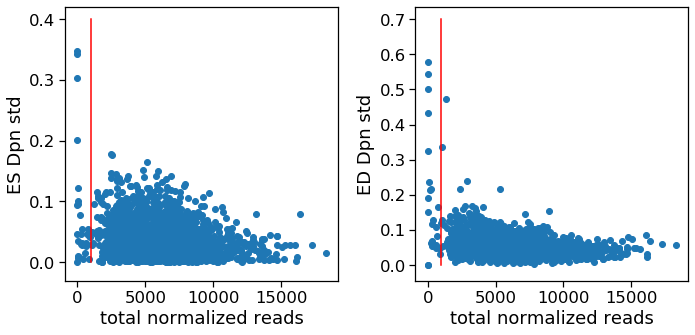

In [62]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.4],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.savefig('plots/threshold_2k_library.svg')

In [69]:
df = df[df['total normalized reads'] > 1000]
df['distance'] = df['distance'].astype(str)

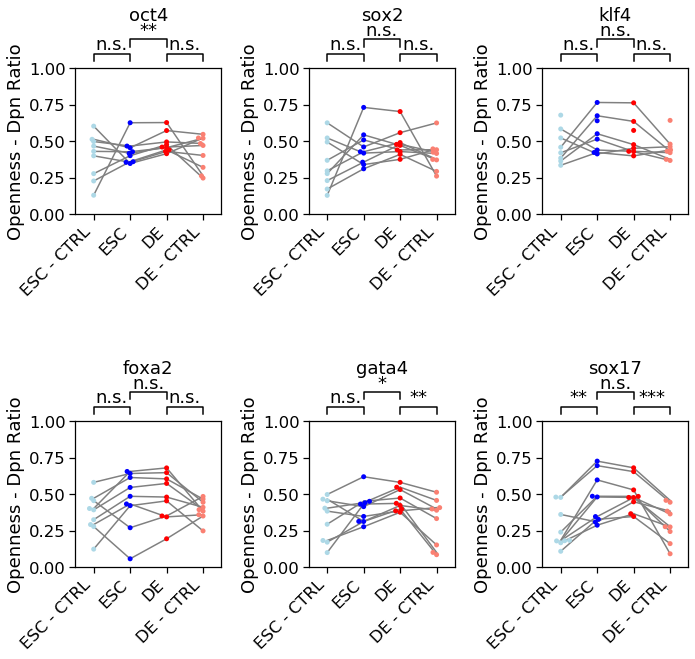

In [65]:
def rename(name):
    newname = ''
    if 'ES' in name:
        newname += 'ESC'
    else:
        newname += 'DE'
    if 'scrambled' in name:
        newname += ' - CTRL'
    return newname
pltind=1
plt.figure(figsize=(10,11))
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']
for tf in tfs:
    plt.subplot(3,3,pltind)
    tfkeep = df[df['tf']==tf]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=tf)
    pltind+=1
plt.savefig('plots/known_motifs_single_instance.svg',bbox_inches='tight')

# Differential compared to scrambled

In [77]:
wilcoxon_tests = {}
ttest_tests = {}
keep = df[df['tf'].isin([c for c in set(df['tf']) for tf in tfs
                                      if ((tf in c))])]
all_cats = list(set(keep['tf']))

for cat in all_cats:
    for distance in set(keep['distance']):
        keep_cat = keep[(keep['tf']==cat)&(keep['control']=='motif')&(keep['distance']==distance)]
        keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
        if len(keep_cat) > 0:
            wilcoxon_tests[cat+'-'+distance] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
            ttest_tests[cat+'-'+distance] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
tests = wilcoxon_tests.keys()
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in tests])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in tests])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(tests) if ttest_true[i] and wilcoxon_true[i]]

In [78]:
wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['tf']))
for cat in all_cats:
    keep_motif = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['tf']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    wilcoxon_tests[cat] = min(es_scram[1],ed_scram[1])
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    ttest_tests[cat] = min(es_scram[1],ed_scram[1])
wilcoxon_pvals = np.array([wilcoxon_tests[cat] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

In [86]:
len(scram_sig_cats)
print(len([c for c in scram_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in scram_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in scram_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in scram_sig_cats]),'/',len([c for c in all_cats]),'total')

2 / 6 singles
17 / 18 pairs
16 / 18 triplets
35 / 42 total


# Differential between cell types

In [84]:
wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['tf']))
for cat in all_cats:
    keep_cat = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    wilcoxon_tests[cat] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    ttest_tests[cat] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

In [87]:
len(scram_sig_cats)
print(len([c for c in diff_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in diff_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in diff_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in diff_sig_cats]),'/',len([c for c in all_cats]),'total')

1 / 6 singles
10 / 18 pairs
6 / 18 triplets
17 / 42 total


# Differential to scrambled and between cell types

In [88]:
scram_wilcoxon_tests = {}
scram_ttest_tests = {}
for cat in diff_sig_cats:
    keep_motif = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['tf']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_wilcoxon_tests[cat] = es_scram
    else:
        scram_wilcoxon_tests[cat] = ed_scram
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_ttest_tests[cat] = es_scram
    else:
        scram_ttest_tests[cat] = ed_scram
wilcoxon_pvals = np.array([scram_wilcoxon_tests[cat][1] for cat in diff_sig_cats])
ttest_pvals = np.array([scram_ttest_tests[cat][1] for cat in diff_sig_cats])

wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_diff_sig_cats = [cat for i,cat in enumerate(diff_sig_cats) if ttest_true[i] and wilcoxon_true[i]]
scram_diff_sig_ordered = sorted(scram_diff_sig_cats,key=lambda x:ttest_tests[x][1])

In [90]:
len(scram_sig_cats)
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]),'singles')
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]),'pairs')
print(len([c for c in scram_diff_sig_cats if len(c.split(','))==3]),'/',len([c for c in all_cats if len(c.split(','))==3]),'triplets')
print(len([c for c in scram_diff_sig_cats]),'/',len([c for c in all_cats]),'total')

0 / 6 singles
9 / 18 pairs
6 / 18 triplets
15 / 42 total


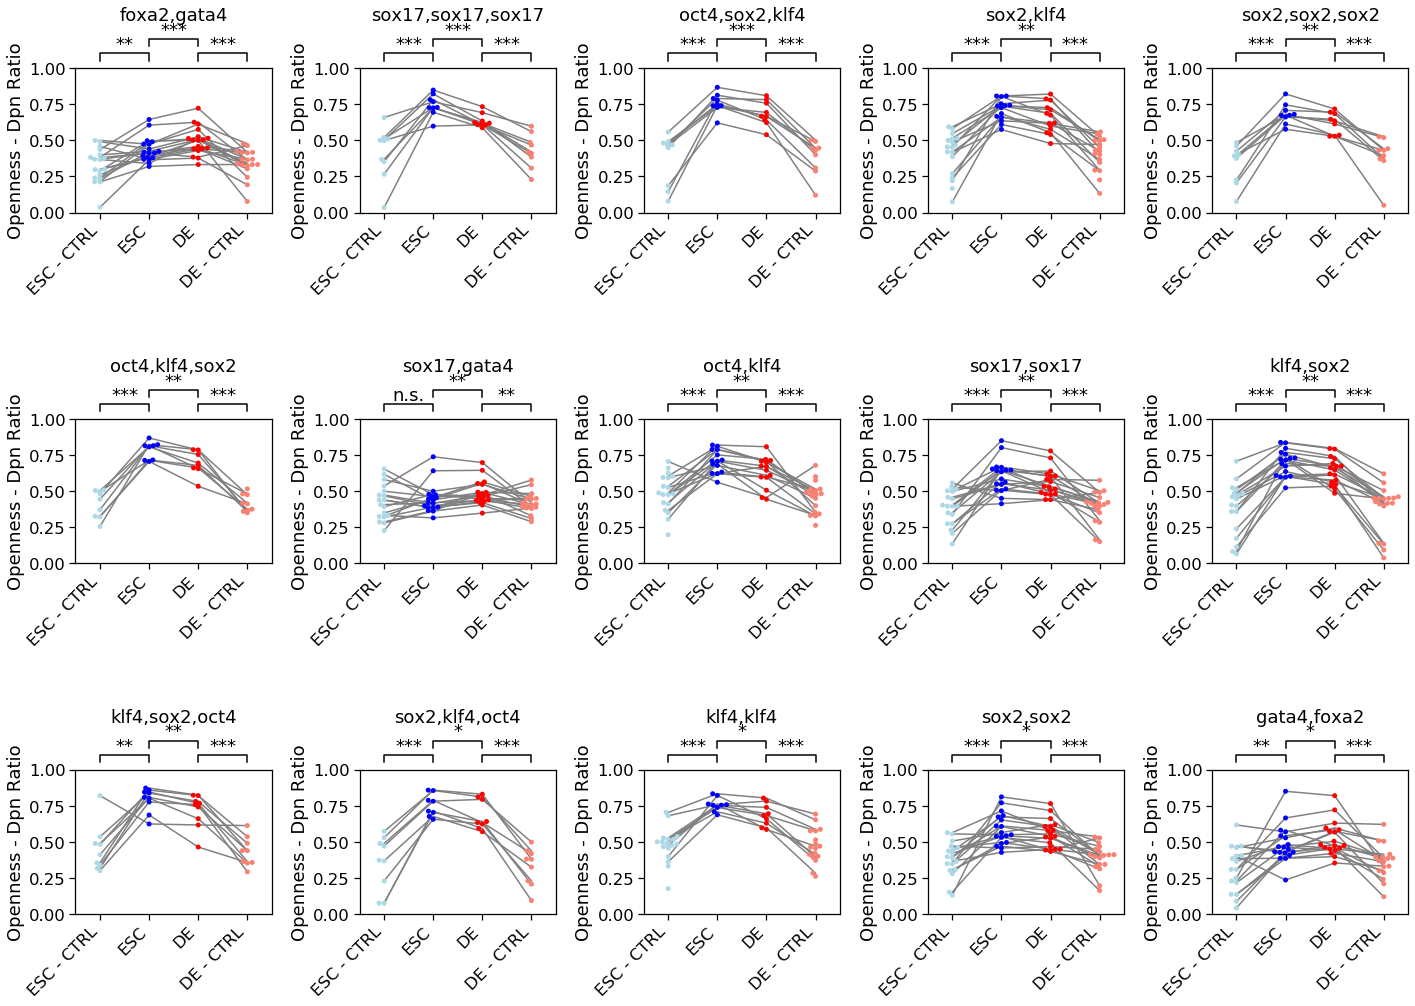

In [94]:
plt.figure(figsize=(20,12))
pltind=1
for cat in scram_diff_sig_ordered:
    plt.subplot(3,5,pltind)
    tfkeep = keep[keep['tf']==cat]        
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=cat)    
    pltind+=1
    
plt.savefig('plots/differentially_significant_combinations.svg',bbox_inches='tight')

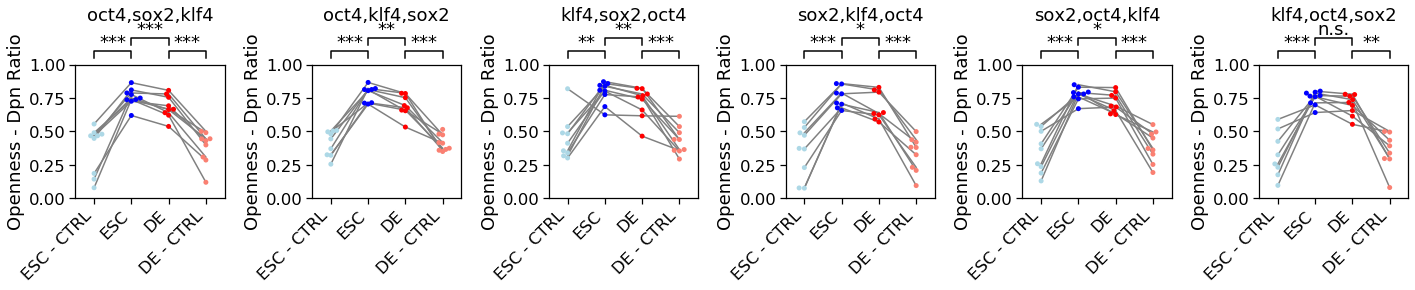

In [96]:
plt.figure(figsize=(20,3))
pltind=1
for cat in ['oct4,sox2,klf4','oct4,klf4,sox2','klf4,sox2,oct4','sox2,klf4,oct4','sox2,oct4,klf4','klf4,oct4,sox2']:
    plt.subplot(1,6,pltind)
    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=cat)    
    pltind+=1    
plt.savefig('plots/OSK_combinations.svg',bbox_inches='tight')

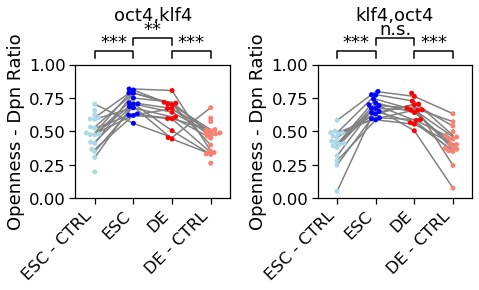

In [97]:
plt.figure(figsize=(7,3))
pltind=1

for cat in ['oct4,klf4','klf4,oct4']:
    plt.subplot(1,2,pltind)
    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=cat)
    pltind += 1
plt.savefig('plots/oct_klf4_combinations.svg',bbox_inches='tight')

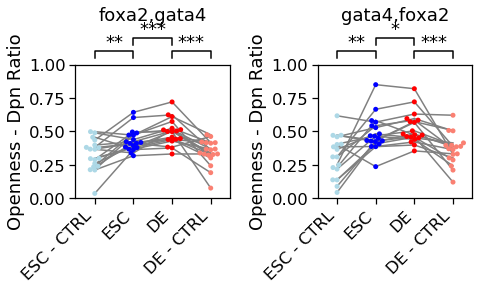

In [98]:
plt.figure(figsize=(7,3))
pltind=1

cat2name={'foxa2,gata4':'Oct4,Klf4','klf4,oct4':'Klf4,Oct4'}
for cat in [c for c in all_cats if 'foxa2' in c and 'gata4' in c and 'sox17' not in c]:
    plt.subplot(1,2,pltind)
    tfkeep = keep[keep['tf']==cat]

    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=cat)
    pltind += 1
plt.savefig('plots/fox_gata_combinations.svg',bbox_inches='tight')

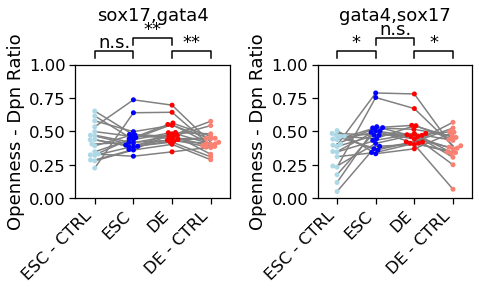

In [99]:
plt.figure(figsize=(7,3))
pltind=1
for cat in ['sox17,gata4','gata4,sox17']:
    plt.subplot(1,2,pltind)
    tfkeep = keep[keep['tf']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','tf','distance','control'],keep_pd,title=cat)
    pltind += 1

plt.savefig('plots/sox_gata_combinations.svg',bbox_inches='tight')